## Challenge Description
We got employee data from a few companies. We have data about all employees who joined from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the company as of 2015/12/13 or they have quit. Beside that, we have general info about the employee, such as avg salary during her tenure, dept, and yrs of experience.

As said above, the goal is to predict employee retention and understand its main drivers. Specifically, you should:


1. Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate employee headcount, for each company on each day, from 2011/01/24 to 2015/12/13. That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have already quit, then company headcount on 2012/03/02 for company 1 would be 1000. You should create a table with 3 columns: day, employee_headcount, company_id


2. What are the main factors that drive employee churn? Do they make sense? Explain your findings


3. If you could add to this data set just one variable that could help explain employee churn, what would that be?

### Create table with employee headcount by day for all companies

In [152]:
from datetime import datetime
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 350)
  
#read from google drive
data=pd.read_csv(".\employee_retention.csv")
  
print(data.head())

#make them a date
data['join_date'] = pd.to_datetime(data['join_date']) 
data['quit_date'] = pd.to_datetime(data['quit_date']) 
  
#everything seems to make sense, some simple plots would help double check that
data.describe(include="all")

   employee_id  company_id              dept  seniority    salary   join_date   quit_date
0      13021.0           7  customer_service         28   89000.0  2014-03-24  2015-10-30
1     825355.0           7         marketing         20  183000.0  2013-04-29  2014-04-04
2     927315.0           4         marketing         14  101000.0  2014-10-13         NaN
3     662910.0           7  customer_service         20  115000.0  2012-05-14  2013-06-07
4     256971.0           2      data_science         23  276000.0  2011-10-17  2014-08-22


,employee_id,company_id,dept,seniority,salary,join_date,quit_date
count,24702.000000,24702.000000,24702,24702.000000,24702.000000,24702,13510
unique,NaN,NaN,6,NaN,NaN,995,664
top,NaN,NaN,customer_service,NaN,NaN,2012-01-03 00:00:00,2015-05-08 00:00:00
freq,NaN,NaN,9180,NaN,NaN,105,111
first,NaN,NaN,NaN,NaN,NaN,2011-01-24 00:00:00,2011-10-13 00:00:00
last,NaN,NaN,NaN,NaN,NaN,2015-12-10 00:00:00,2015-12-09 00:00:00
mean,501604.403530,3.426969,NaN,14.127803,138183.345478,NaN,NaN
std,288909.026101,2.700011,NaN,8.089520,76058.184573,NaN,NaN
min,36.000000,1.000000,NaN,1.000000,17000.000000,NaN,NaN
25%,250133.750000,1.000000,NaN,7.000000,79000.000000,NaN,NaN


In [97]:
  #create list of unique dates for the tables
unique_dates = pd.date_range(start='2011/01/24', end='2015/12/13')
  
#create list of unique companies
unique_companies = data['company_id'].unique()
  
#cross join so I get all combinations of dates and companies. Will need it later.
data_headcount = pd.MultiIndex.from_product([unique_dates, unique_companies], names = ["date", "company_id"])
data_headcount = pd.DataFrame(index = data_headcount).reset_index()
  
#now I get for each day/company, how many people quit/got hired on that day
data_join = data.groupby(['join_date', 'company_id']).size().reset_index(name='join_count')
data_join.columns.values[0]='date'
data_quit = data.groupby(['quit_date', 'company_id']).size().reset_index(name='quit_count')
data_quit.columns.values[0]='date'
  
#Now I left outer join with data_headcount. 
#NA means no people were hired/quit on that day cause there is no match.
data_headcount = pd.merge(data_headcount, data_join, on=["date", "company_id"], how='left')
data_headcount = pd.merge(data_headcount, data_quit, on=["date", "company_id"], how='left')
  
#replace the NAs with 0
data_headcount.fillna(0, inplace=True)
  
#Now I need the sum by company_id. Data set is already ordered by date, so I can simply group by company_id and do cumsum
data_headcount['cumsum_join'] = data_headcount.groupby(['company_id'])['join_count'].apply(lambda x: x.cumsum())
data_headcount['cumsum_quit'] = data_headcount.groupby(['company_id'])['quit_count'].apply(lambda x: x.cumsum())
  
#finally, for each date I just take join_count - quit_count and I am done
data_headcount['count'] = data_headcount['cumsum_join'] - data_headcount['cumsum_quit']
data_headcount_table = data_headcount[["date", "company_id","count"]]
  
#let's check company 1
print(data_headcount_table.query("company_id == 1").head(15))

          date  company_id  count
4   2011-01-24           1   25.0
16  2011-01-25           1   27.0
28  2011-01-26           1   29.0
40  2011-01-27           1   29.0
52  2011-01-28           1   29.0
64  2011-01-29           1   29.0
76  2011-01-30           1   29.0
88  2011-01-31           1   59.0
100 2011-02-01           1   66.0
112 2011-02-02           1   67.0
124 2011-02-03           1   67.0
136 2011-02-04           1   67.0
148 2011-02-05           1   67.0
160 2011-02-06           1   67.0
172 2011-02-07           1   99.0


In [98]:
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [99]:
# derive more features:
# quit flag
data['quit_flag'] = np.where(data['quit_date'].isnull(), 0, 1)
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit_flag
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,1
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1


In [100]:
# tenure
data['tenure'] = (data['quit_date'] -  data['join_date'])/np.timedelta64(1, 'Y')
data.head()
# since the cutoff point is 2015/12/13, we can also calculate the tenure of existing employees as at that time

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit_flag,tenure
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,1,1.601676
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1,0.930888
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,0,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1,1.065046
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1,2.847423


In [101]:
data['tenure'] = np.where(data['quit_date'].isnull(), (pd.to_datetime('2015/12/13') -  data['join_date'])/np.timedelta64(1, 'Y'), (data['quit_date'] -  data['join_date'])/np.timedelta64(1, 'Y'))

In [102]:
data

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit_flag,tenure
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,1,1.601676
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1,0.930888
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,0,1.166348
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1,1.065046
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1,2.847423
...,...,...,...,...,...,...,...,...,...
24697,549847.0,3,customer_service,16,97000.0,2015-02-18,NaT,0,0.815896
24698,590087.0,4,engineer,10,160000.0,2015-10-26,NaT,0,0.131420
24699,777612.0,4,customer_service,11,67000.0,2013-09-03,2015-10-23,1,2.135567
24700,97289.0,10,engineer,98,266000.0,2011-12-13,2015-01-09,1,3.074670


In [103]:
# to create individual day, month and year
data['quit_day'] = data['quit_date'].dt.day
data['quit_month'] = data['quit_date'].dt.month
data['quit_year'] = data['quit_date'].dt.year
data.head()

,employee_id,company_id,dept,seniority,salary,...,quit_flag,tenure,quit_day,quit_month,quit_year
0,13021.0,7,customer_service,28,89000.0,...,1,1.601676,30.0,10.0,2015.0
1,825355.0,7,marketing,20,183000.0,...,1,0.930888,4.0,4.0,2014.0
2,927315.0,4,marketing,14,101000.0,...,0,1.166348,NaN,NaN,NaN
3,662910.0,7,customer_service,20,115000.0,...,1,1.065046,7.0,6.0,2013.0
4,256971.0,2,data_science,23,276000.0,...,1,2.847423,22.0,8.0,2014.0


In [104]:
# again summarize
data.describe(include = 'all')

,employee_id,company_id,dept,seniority,salary,...,quit_flag,tenure,quit_day,quit_month,quit_year
count,24702.000000,24702.000000,24702,24702.000000,24702.000000,...,24702.000000,24702.000000,13510.000000,13510.000000,13510.00000
unique,NaN,NaN,6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,customer_service,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,9180,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
mean,501604.403530,3.426969,NaN,14.127803,138183.345478,...,0.546919,1.572432,15.886306,6.550925,2013.83242
std,288909.026101,2.700011,NaN,8.089520,76058.184573,...,0.497804,0.990006,8.813845,3.408746,1.05116
min,36.000000,1.000000,NaN,1.000000,17000.000000,...,0.000000,0.008214,1.000000,1.000000,2011.00000
25%,250133.750000,1.000000,NaN,7.000000,79000.000000,...,0.000000,0.911723,8.000000,4.000000,2013.00000


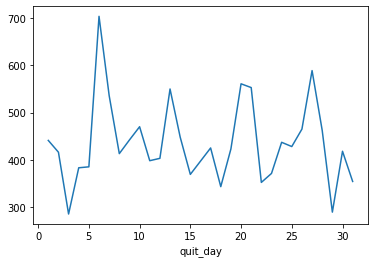

In [105]:
# data explore and vizulisation
data.groupby(['quit_day']).size().plot()

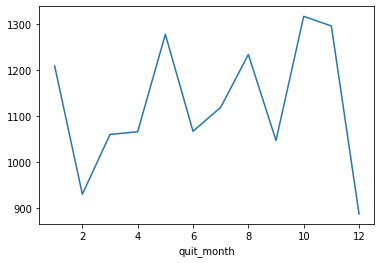

In [106]:
# data explore and vizulisation
data.groupby(['quit_month']).size().plot()

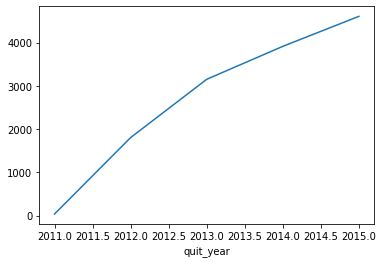

In [107]:
# data explore and vizulisation
data.groupby(['quit_year']).size().plot()

In [108]:
data.groupby(['company_id']).size()

company_id
1     8486
2     4222
3     2749
4     2062
5     1755
6     1291
7     1224
8     1047
9      961
10     865
11      16
12      24
dtype: int64

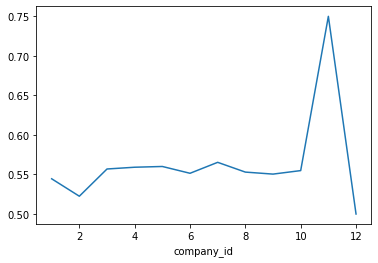

In [109]:
# inspect quit rate by company
data.groupby(['company_id'])['quit_flag'].mean().plot()
# we can see that company 11 has higher quit rate while company 12 is rather low
# however, their absolute amoount (company size is small too)
# among the bigger companies, company 2 has slightly lower quit rate

In [110]:
data.groupby(['dept']).size()

dept
customer_service    9180
data_science        3190
design              1380
engineer            4613
marketing           3167
sales               3172
dtype: int64

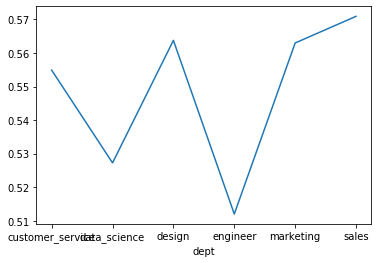

In [111]:
# inspect quit rate by department
data.groupby(['dept'])['quit_flag'].mean().plot()
# highest for sales, lowest for engineer

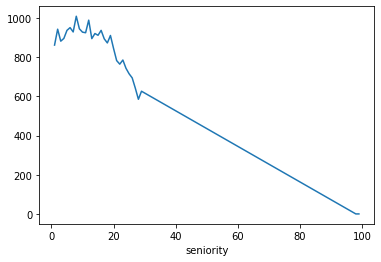

In [112]:
data.groupby(['seniority']).size().plot()

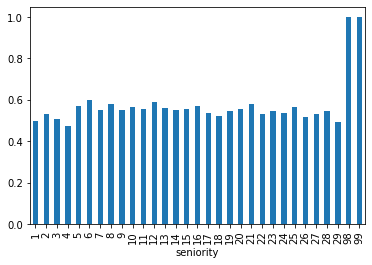

In [113]:
# inspect quit rate by seniority
data.groupby(['seniority'])['quit_flag'].mean().plot(kind='bar')
# looks quite even..the last 2 can be ignored as the sample sizes are both 2

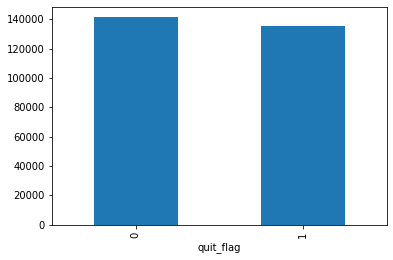

In [114]:
# average salary for quiters and non-quiters
data.groupby(['quit_flag'])['salary'].mean().plot(kind='bar')
# average quitter salary is lower than non-quitters

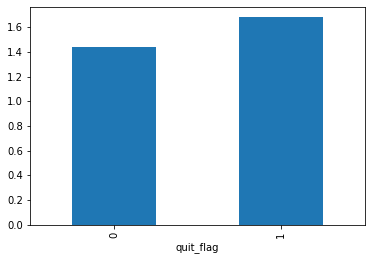

In [115]:
# average salary for quiters and non-quiters
data.groupby(['quit_flag'])['tenure'].mean().plot(kind='bar')
# average quitter tenure is higher than non-quitters

In [116]:
print(data.isnull().sum())

employee_id        0
company_id         0
dept               0
seniority          0
salary             0
join_date          0
quit_date      11192
quit_flag          0
tenure             0
quit_day       11192
quit_month     11192
quit_year      11192
dtype: int64


In [117]:
# count for quitter's companies at at quitting date
data_headcount_table.head()

,date,company_id,count
0,2011-01-24,7,1.0
1,2011-01-24,4,12.0
2,2011-01-24,2,17.0
3,2011-01-24,9,3.0
4,2011-01-24,1,25.0


In [118]:
# merge headcount at add quit date for quitters
quitters = data[data['quit_flag'] == 1]
quitters = pd.merge(quitters, data_headcount_table, how = 'left', left_on =['company_id', 'quit_date'], right_on =['company_id', 'date'])
print(quitters.isnull().sum())

employee_id    0
company_id     0
dept           0
seniority      0
salary         0
join_date      0
quit_date      0
quit_flag      0
tenure         0
quit_day       0
quit_month     0
quit_year      0
date           0
count          0
dtype: int64


In [119]:
# counts are also needs to be filled for employees that didn't quit. the count should be the headcount as at 2015/12/13 for each company
non_quitters = data[data['quit_flag'] == 0]
end_headct = data_headcount_table[data_headcount_table['date']=="2015/12/13"]
non_quitters = pd.merge(data, end_headct, how = 'left', left_on =['company_id'], right_on =['company_id'])
print(non_quitters.isnull().sum())

employee_id        0
company_id         0
dept               0
seniority          0
salary             0
join_date          0
quit_date      11192
quit_flag          0
tenure             0
quit_day       11192
quit_month     11192
quit_year      11192
date               0
count              0
dtype: int64


In [120]:
# append data_headcount_table and end_headct to be merged with the main table
data = pd.concat([non_quitters,quitters])
data.head()

,employee_id,company_id,dept,seniority,salary,...,quit_day,quit_month,quit_year,date,count
0,13021.0,7,customer_service,28,89000.0,...,30.0,10.0,2015.0,2015-12-13,532.0
1,825355.0,7,marketing,20,183000.0,...,4.0,4.0,2014.0,2015-12-13,532.0
2,927315.0,4,marketing,14,101000.0,...,NaN,NaN,NaN,2015-12-13,909.0
3,662910.0,7,customer_service,20,115000.0,...,7.0,6.0,2013.0,2015-12-13,532.0
4,256971.0,2,data_science,23,276000.0,...,22.0,8.0,2014.0,2015-12-13,2016.0


In [121]:
# train test split
# drop the extra variables
data = data.drop(['quit_day', 'quit_month','quit_year', 'quit_date', 'date', 'join_date'], axis = 1)
data.head()

,employee_id,company_id,dept,seniority,salary,quit_flag,tenure,count
0,13021.0,7,customer_service,28,89000.0,1,1.601676,532.0
1,825355.0,7,marketing,20,183000.0,1,0.930888,532.0
2,927315.0,4,marketing,14,101000.0,0,1.166348,909.0
3,662910.0,7,customer_service,20,115000.0,1,1.065046,532.0
4,256971.0,2,data_science,23,276000.0,1,2.847423,2016.0


In [122]:
X = data.drop(['quit_flag'], axis = 1)
y = data.iloc[:, 5]
# split the data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_test[['salary']]

,salary
9435,154000.0
10959,36000.0
11803,145000.0
15098,26000.0
9871,63000.0
...,...
154,98000.0
8365,165000.0
12280,159000.0
17235,101000.0


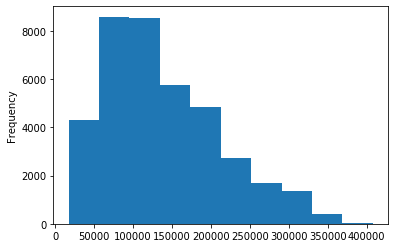

In [123]:
# scale salary & seniority 
# plot salary first
data['salary'].plot(kind = "hist")
# skewed, thus need to be scaled
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [124]:
# scale salary
X_train['salary'] = sc.fit_transform(X_train[['salary']])
X_test['salary'] = sc.fit_transform(X_test[['salary']])

In [125]:
# scale seniority
X_train['seniority'] = sc.fit_transform(X_train[['seniority']])
X_test['seniority'] = sc.fit_transform(X_test[['seniority']])
X_train

,employee_id,company_id,dept,seniority,salary,tenure,count
21860,682685.0,6,sales,1.220965,0.221738,0.958267,579.0
11323,287265.0,1,marketing,-0.766300,-0.355658,3.115738,3865.0
12614,33010.0,10,engineer,-0.517891,0.248594,0.755662,214.0
2615,883760.0,1,sales,0.227333,1.121402,0.854227,3842.0
2144,172622.0,7,engineer,0.724149,0.691711,1.114328,474.0
...,...,...,...,...,...,...,...
20757,370747.0,1,data_science,-0.269483,0.691711,1.300506,3865.0
7401,962902.0,10,design,1.345170,0.315733,1.045880,380.0
5701,798128.0,5,engineer,-1.511524,-1.161327,0.950054,647.0
21243,280423.0,1,engineer,-1.387320,-0.771920,0.936364,3865.0


In [134]:
# encode company_id, dept 
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
comp_id = ohe.fit_transform(X_train[['company_id']]).toarray()
comp_id_cols = ohe.get_feature_names(['company_id'])
dept = ohe.fit_transform(X_train[['dept']]).toarray()
dept_cols = ohe.get_feature_names(['dept'])
# add the encoded ones to the dataset train and test sets
comp_id = pd.DataFrame(comp_id, columns = comp_id_cols)
comp_id.shape

(30569, 12)

In [135]:
dept = pd.DataFrame(dept, columns = dept_cols)
X_train = pd.concat([X_train.reset_index(drop = True), comp_id], axis = 1)
X_train = pd.concat([X_train.reset_index(drop = True), dept], axis = 1)
X_train.columns

Index(['employee_id', 'company_id', 'dept', 'seniority', 'salary', 'tenure', 'count', 'company_id_1', 'company_id_2', 'company_id_3', 'company_id_4', 'company_id_5', 'company_id_6', 'company_id_7', 'company_id_8', 'company_id_9', 'company_id_10', 'company_id_11', 'company_id_12', 'dept_customer_service', 'dept_data_science', 'dept_design',
       'dept_engineer', 'dept_marketing', 'dept_sales'],
      dtype='object')

In [126]:
# encode company_id, dept 
comp_id = ohe.fit_transform(X_test[['company_id']]).toarray()

In [127]:
comp_id_cols = ohe.get_feature_names(['company_id'])

In [129]:
dept = ohe.fit_transform(X_test[['dept']]).toarray()
dept_cols = ohe.get_feature_names(['dept'])

In [130]:
# add the encoded ones to the dataset train and test sets
comp_id = pd.DataFrame(comp_id, columns = comp_id_cols)
comp_id.shape

(7643, 12)

In [131]:
dept = pd.DataFrame(dept, columns = dept_cols)

In [132]:
X_test = pd.concat([X_test.reset_index(drop = True), comp_id], axis = 1)

In [133]:
X_test = pd.concat([X_test.reset_index(drop = True), dept], axis = 1)
X_test.columns

Index(['employee_id', 'company_id', 'dept', 'seniority', 'salary', 'tenure', 'count', 'company_id_1', 'company_id_2', 'company_id_3', 'company_id_4', 'company_id_5', 'company_id_6', 'company_id_7', 'company_id_8', 'company_id_9', 'company_id_10', 'company_id_11', 'company_id_12', 'dept_customer_service', 'dept_data_science', 'dept_design',
       'dept_engineer', 'dept_marketing', 'dept_sales'],
      dtype='object')

In [136]:
# try simple logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [141]:
X_train.drop(['company_id', 'dept', 'employee_id'], axis = 1, inplace = True)
X_test.drop(['company_id', 'dept', 'employee_id'], axis = 1, inplace = True)

In [155]:
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [156]:
y_perd = logreg.predict(X_train)
y_perd

array([1, 1, 1, ..., 1, 1, 1])

In [157]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion= 'entropy', random_state = 0)
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [158]:
y_pred = tree.predict(X_test)
y_pred[1:20]

array([1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1])

In [159]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
cm = confusion_matrix(y_test, y_pred)
cm

array([[1833,  410],
       [ 392, 5008]], dtype=int64)

In [160]:
accuracy_score(y_test, y_pred)

0.895067381918095

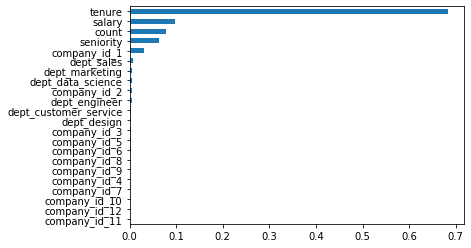

In [161]:
feat_importance = pd.Series(tree.feature_importances_, index = X_train.columns)
feat_importance.sort_values().plot(kind = 'barh')
plt.show()

Tenure, salary and count as at quitting and seniority play larger roles than company and department.

Seniority as at joining and quitting

Salary as at joining and quitting

No. of promotions in last three years

Scale of Satisfaction level

## Summary
- data['tenure'] = (data['quit_date'] -  data['join_date'])/np.timedelta64(1, 'Y') 
- np.where is useful in some simple if/else condition